### Neale Ellyson
## MSE 608: Project 8

In [1]:
import hoomd
import hoomd.md
import numpy
import ex_render
import freud 
import matplotlib.pyplot as plt
import time
%matplotlib inline
temperatures = {}
data = {}
EQtemp = {}
EQdata = {}
analysis = {}
EQanalysis = {}

In [34]:
class rdf_analyze:
    def __init__(self, system):
        self.system = system;
        self.rdf = freud.density.RDF(rmax=2.0, dr=0.01); #Can update range and stepsize here
        
    def __call__(self, step):
        '''This special function defines what happens when we "register" the callback below'''
        snap = self.system.take_snapshot();
        pos = snap.particles.position;
        box = freud.box.Box(snap.box.Lx, snap.box.Ly, snap.box.Lz);
        self.rdf.accumulate(box, pos, pos);

In [35]:
def size(N): # Creates position vectors and bond groups for
    line = numpy.linspace(-(N//2-.5),(N//2-.5),num=N)
    position = numpy.insert(numpy.zeros((N,2)), 0, line, axis=1)
    bondPP = [[0,1], [1,2], [2,3], [3,4]]
    addbonds = numpy.insert(numpy.arange(5,N).reshape(N-5,1),0,numpy.linspace(4,N-2,num=N-5),axis=1)
    bondgroup = numpy.concatenate((bondPP, addbonds))
    return position,bondgroup

In [36]:
def run(N,position,bondgroup,kT,tau,period,tsteps):
    hoomd.context.initialize("");
    # Mike says "This is initializing the longer way than a lattice"
    snapshot = hoomd.data.make_snapshot(N=N, # Number of atoms in a particle
                                        box=hoomd.data.boxdim(Lx=N, Ly=0.5, Lz=0.5),
                                        particle_types=['A', 'B'],
                                        bond_types=['polymer']); # Single bond type
    snapshot.particles.position[:] = position
    snapshot.particles.typeid[0:(N//2-1)]=0;  # Blue particles = A
    snapshot.particles.typeid[N//2:N]=1; # Orange particles = B
    snapshot.bonds.resize(N-1);
    snapshot.bonds.group[:] = bondgroup
    snapshot.replicate(1,2*N,2*N); # Makes boxdim equal across the L dimensions
    hoomd.init.read_snapshot(snapshot);
    nl = hoomd.md.nlist.cell();
    dpd = hoomd.md.pair.dpd(r_cut=1.0, nlist=nl, kT=kT, seed=1); # NOT Dissipative Particle Dynamics, LJ
    dpd.pair_coeff.set('A', 'A', A=25.0, gamma = 1.0);
    dpd.pair_coeff.set('A', 'B', A=75.0, gamma = 1.0);
    dpd.pair_coeff.set('B', 'B', A=25.0, gamma = 1.0);
    nl.reset_exclusions(exclusions = []);
    harmonic = hoomd.md.bond.harmonic();
    harmonic.bond_coeff.set('polymer', k=100.0, r0=0);
    hoomd.md.integrate.mode_standard(dt=0.005);
    all = hoomd.group.all();
    integrator = hoomd.md.integrate.nvt(group=all,kT=kT,tau=tau);
    integrator.randomize_velocities(seed=42)
    hoomd.analyze.log(filename="size-"+str(N)+".log",
                      quantities=['potential_energy','kinetic_energy','temperature','time'],
                      period=period ,
                      overwrite=True);
    hoomd.dump.gsd("traj-size-"+str(N)+".gsd", period=tsteps/10 , group=all, overwrite=True);
    hoomd.run(tsteps);
    data = numpy.genfromtxt(fname="size-"+str(N)+".log", skip_header=True);
    return data

In [37]:
def EQrun(kT,tau,period,tsteps):
    hoomd.context.initialize("");
    system = hoomd.init.read_gsd("traj-size-"+str(N)+".gsd", frame=-1, time_step=0)
    EQanalysis = rdf_analyze(system); # Create the RDF analyzer using our class in the above cell
    hoomd.analyze.callback(EQanalysis, period=period); #Registration of the RDF callback every 100 steps
    nl = hoomd.md.nlist.cell();
    dpd = hoomd.md.pair.dpd(r_cut=1.0, nlist=nl, kT=kT, seed=1); # NOT Dissipative Particle Dynamics, LJ
    dpd.pair_coeff.set('A', 'A', A=25.0, gamma = 1.0);
    dpd.pair_coeff.set('A', 'B', A=75.0, gamma = 1.0);
    dpd.pair_coeff.set('B', 'B', A=25.0, gamma = 1.0);
    nl.reset_exclusions(exclusions = []);
    harmonic = hoomd.md.bond.harmonic();
    harmonic.bond_coeff.set('polymer', k=100.0, r0=0);
    hoomd.md.integrate.mode_standard(dt=0.005);
    all = hoomd.group.all();
    integrator = hoomd.md.integrate.nvt(group=all,kT=kT,tau=tau);
    integrator.randomize_velocities(seed=42)
    hoomd.analyze.log(filename="EQ-size-"+str(N)+".log",
                      quantities=['potential_energy','kinetic_energy','temperature','time'],
                      period=period ,
                      overwrite=True);
    hoomd.dump.gsd("EQtraj-size-"+str(N)+".gsd", period=tsteps/10 , group=all, overwrite=True);
    hoomd.run(tsteps);
    data = numpy.genfromtxt(fname="EQ-size-"+str(N)+".log", skip_header=True);
    return data,EQanalysis

In [38]:
numpy.arange(5,11,2)

array([5, 7, 9])

In [39]:
#N = 10 # Must be at least 10 and an even number; 40,~5:56min; 30,~2:24min; 20,~0:38
#kT = 1 # Using range 0.1<kT<10
Sizes = numpy.arange(5,11,1)
Temps = numpy.arange(1,2,2)
tau = 0.1
period = 100
tsteps = 1e4
start = time.time()
for N in Sizes:
    pos,bonds = size(N)
    onerun = []
    oneEQrun = []
    analysisrun = []
    for kT in Temps:
        print("\n Starting run with",N,"particles at a temperature of", kT,"\n")
        temperatures[kT] = run(N,pos,bonds,kT,tau,period,tsteps)
        onerun.append(temperatures[kT])
        data[N] =  numpy.array(onerun)
        print("\n Starting Equilirbrium Run")
        EQtemp[kT],analysis[kT] = EQrun(kT,tau,period,tsteps)
        oneEQrun.append(EQtemp[kT])
        analysisrun.append(analysis[kT])
        EQdata[N] = numpy.array(oneEQrun)
        EQanalysis[N] = numpy.array(analysisrun)
finish = time.time()
print('This took',(finish-start)/60,'minutes, or',(finish-start)/60/60,'hours')


 Starting run with 5 particles at a temperature of 1 

notice(2): Group "all" created containing 500 particles
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 500
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:09 | Step 10000 / 10000 | TPS 1056.11 | ETA 00:00:00
Average TPS: 1055.99
---------
-- Neighborlist stats:
876 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 47 / n_neigh_avg: 22.332
shortest rebuild period: 6
-- Cell list stats:
Dimension: 3, 3, 3
n_min    : 14 / n_max: 23 / n_avg: 18.5185
** run complete **

 

Time 00:00:20 | Step 5709 / 10000 | TPS 298.492 | ETA 00:00:14
Time 00:00:30 | Step 8730 / 10000 | TPS 302.079 | ETA 00:00:04
Time 00:00:34 | Step 10000 / 10000 | TPS 295.401 | ETA 00:00:00
Average TPS: 291.527
---------
-- Neighborlist stats:
952 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 52 / n_neigh_avg: 22.9072
shortest rebuild period: 8
-- Cell list stats:
Dimension: 5, 5, 5
n_min    : 10 / n_max: 22 / n_avg: 16.384
** run complete **

 Starting run with 9 particles at a temperature of 1 

notice(2): Group "all" created containing 2916 particles
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 2916
notic

In [54]:
print([1/6,2/7,3/8,4/9,5/10])
z = 6
del_w = 75-0.5*(25-25)
kB = 0.00831445986144858
chi = z*del_w/kB/kT
print(chi)

[0.16666666666666666, 0.2857142857142857, 0.375, 0.4444444444444444, 0.5]
54122.57771385754


IndexError: index 1 is out of bounds for axis 0 with size 1

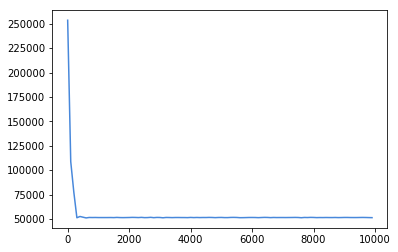

In [38]:
plt.figure()
plt.plot(data[10][0][:,0],data[10][0][:,1],label='kT=0.01',color='#4888db')
#plt.plot(data[10][1][:,0],data[10][1][:,1],label='kT=1.7575',color='#f79501')
#plt.plot(data[10][-1][:,0],data[10][-1][:,1],label='kT=7',color='#c63939')
plt.xlabel('time step')
plt.ylabel('potential_energy')
plt.legend()

IndexError: index 1 is out of bounds for axis 0 with size 1

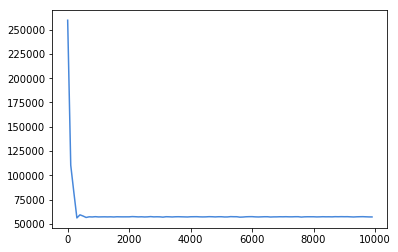

In [43]:
plt.figure()
plt.plot(data[10][0][:,0],data[10][0][:,1]+data[10][0][:,2],label='kT=0.01',color='#4888db')
#plt.plot(data[10][1][:,0],data[10][1][:,1]+data[10][1][:,2],label='kT=kT=1.7575',color='#f79501')
#plt.plot(data[10][-1][:,0],data[10][-1][:,1]+data[10][-1][:,2],label='kT=7',color='#c63939')
plt.xlabel('time step')
plt.ylabel('total_energy')
plt.legend()

Text(0, 0.5, 'g_AA')

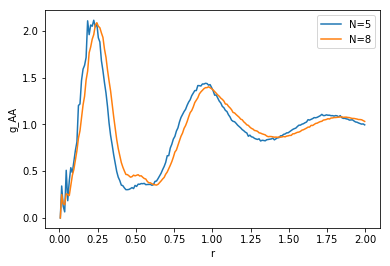

In [51]:
plt.figure()
Sizes = numpy.arange(5,11,3)#numpy.arange(5,11,1)
for N in Sizes:
    plt.plot(EQanalysis[N][0].rdf.R, EQanalysis[N][0].rdf.RDF,label=f"N={N}")
#plt.plot(EQanalysis[10][1].rdf.R, EQanalysis[10][1].rdf.RDF,label='kT=1.7575',color='#f79501')
#plt.plot(EQanalysis[10][-1].rdf.R, EQanalysis[10][-1].rdf.RDF,label='kT=7',color='#c63939')
plt.legend()
plt.xlabel('r')
plt.ylabel('g_AA')

In [ ]:
ex_render.display_movie(ex_render.render_sphere_frame, 'trajectory.gsd') # Takes some time

In [46]:
EQanalysis

{10: array([<__main__.rdf_analyze object at 0x12d37eb00>], dtype=object),
 5: array([<__main__.rdf_analyze object at 0x1289e5b38>], dtype=object),
 6: array([<__main__.rdf_analyze object at 0x128f08ac8>], dtype=object),
 7: array([<__main__.rdf_analyze object at 0x12d36c668>], dtype=object),
 8: array([<__main__.rdf_analyze object at 0x12d36c320>], dtype=object),
 9: array([<__main__.rdf_analyze object at 0x12d38a748>], dtype=object)}